<a href="https://colab.research.google.com/github/ednei-code/An-lise-das-Luas-do-Sistema-Solar-com-Ci-ncia-de-Dados/blob/main/luas_sistema_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise das Luas do Sistema Solar com Ciência de Dados

**Autor:** Ednei Cunha Vicente - Cientista de Dados

**Ferramentas:** Python · Pandas · Matplotlib · Scikit-learn
  
**Contexto:** Astrofísica · Ciência de Dados · Estatística

---

As luas do Sistema Solar constituem um laboratório natural para o estudo de processos físicos, dinâmicos e composicionais associados à formação e evolução planetária. Diferentes sistemas planetários abrigam luas com ampla diversidade de tamanhos, massas, densidades e órbitas, refletindo histórias evolutivas distintas.

Neste projeto, adotamos uma abordagem comparativa global, utilizando dados físicos e orbitais consolidados das luas do Sistema Solar para investigar padrões emergentes por meio de análise exploratória, inferência estatística e técnicas de aprendizado não supervisionado.


## Objetivo do Projeto

Investigar relações físicas e orbitais entre as luas do Sistema Solar, avaliando se essas propriedades permitem identificar grupos naturais de luas com características semelhantes, sem recorrer a rótulos pré-definidos.

## Pergunta Central

**Quais padrões físicos e orbitais emergem quando analisamos as luas do Sistema Solar em conjunto, e elas se organizam naturalmente em grupos com propriedades semelhantes?**


## Plano de Análise

Este projeto será desenvolvido de forma iterativa e exploratória, seguindo as etapas abaixo:

1. Descrição da origem e natureza dos dados
2. Auditoria inicial e preparação do dataset
3. Análise exploratória (EDA) com interpretação física
4. Formulação e execução de testes de hipótese estatísticos
5. Clusterização exploratória das luas
6. Análise dirigida de um cluster específico
7. Conclusão e discussão de limitações e extensões

O escopo poderá ser ajustado ao longo do desenvolvimento, conforme novos insights emerjam dos dados.


In [1]:
# ============================================
# Setup do Projeto e Importação de Bibliotecas
# ============================================

# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Estatística
from scipy.stats import mannwhitneyu, kruskal

# Pré-processamento e clusterização
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visual Analytics para ML (clusterização)
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Configurações visuais globais
plt.style.use('ggplot')
sns.set_context("notebook")



## Fonte e Créditos dos Dados

Os dados utilizados neste projeto foram obtidos a partir da base Planetary Satellite Physical Parameters, mantida pelo Jet Propulsion Laboratory (JPL), um centro de pesquisa da NASA.
O JPL é responsável pela curadoria e disponibilização de dados consolidados sobre corpos do Sistema Solar, amplamente utilizados pela comunidade científica em estudos educacionais e exploratórios.

Base de dados: https://ssd.jpl.nasa.gov/sats/phys_par/

Jet Propulsion Laboratory (JPL): https://www.jpl.nasa.gov/

NASA: https://www.nasa.gov/

Este conjunto de dados reúne parâmetros físicos e orbitais médios das luas do Sistema Solar, derivados de observações astronômicas, modelos dinâmicos e resultados de missões espaciais. Os valores apresentados representam estimativas aceitas pela comunidade científica e são amplamente utilizados como referência em estudos educacionais e exploratórios.

É importante ressaltar que este dataset:
- não contém dados instrumentais brutos;
- não representa séries temporais;
- descreve propriedades médias consolidadas.

Por essas características, os dados são adequados para análises comparativas, inferência estatística e técnicas de aprendizado não supervisionado, respeitando as limitações inerentes a parâmetros agregados.


In [2]:
#carregamento dos dados
url = "https://ssd.jpl.nasa.gov/sats/phys_par/"
tables = pd.read_html(url)

len(tables), [t.shape for t in tables[:3]]


(3, [(46, 12), (7, 3), (3, 2)])

In [3]:
# ============================================
# Seleção da tabela principal (luas do Sistema Solar)
# ============================================

# A primeira tabela contém os parâmetros físicos das luas
df = tables[0].copy()

# Visualização inicial
df.head()


Planet Satellite Code GM (km3/s2)                       Mean Radius (km)  \
    Planet Satellite Code       value         sigma     ref            value   
0    Earth      Moon  301    4902.800  1.000000e-03   DE440          1737.40   
1     Mars    Phobos  401   0.0007087  6.000000e-07  MAR097            11.08   
2     Mars    Deimos  402   0.0000962  2.800000e-06  MAR097             6.20   
3  Jupiter        Io  501  5959.91547  1.350000e-03  JUP365          1821.49   
4  Jupiter    Europa  502  3202.71210  1.810000e-03  JUP365          1560.80   

            Mean Density (g/cm3)              
  sigma ref                value   sigma ref  
0  0.10   1               3.3440  0.0010   *  
1  0.04   1               1.8720  0.0760   *  
2  0.24   1               1.4710  0.1660   *  
3  0.50   1               3.5276  0.0029   *  
4  0.30   1               3.0130  0.0017   *

In [4]:
# ============================================
# Normalização inicial da estrutura do dataset
# ============================================

# Copiar dataframe original
df_clean = df.copy()

# Achatar MultiIndex:
# - se os níveis forem iguais, usa só um
# - se forem diferentes, concatena
df_clean.columns = [
    col[0] if col[0] == col[1] else f"{col[0]}_{col[1]}"
    for col in df_clean.columns
]

df_clean.head()


,Planet,Satellite,Code,GM (km3/s2)_value,GM (km3/s2)_sigma,GM (km3/s2)_ref,Mean Radius (km)_value,Mean Radius (km)_sigma,Mean Radius (km)_ref,Mean Density (g/cm3)_value,Mean Density (g/cm3)_sigma,Mean Density (g/cm3)_ref
0,Earth,Moon,301,4902.800,1.000000e-03,DE440,1737.40,0.10,1,3.3440,0.0010,*
1,Mars,Phobos,401,0.0007087,6.000000e-07,MAR097,11.08,0.04,1,1.8720,0.0760,*
2,Mars,Deimos,402,0.0000962,2.800000e-06,MAR097,6.20,0.24,1,1.4710,0.1660,*
3,Jupiter,Io,501,5959.91547,1.350000e-03,JUP365,1821.49,0.50,1,3.5276,0.0029,*
4,Jupiter,Europa,502,3202.71210,1.810000e-03,JUP365,1560.80,0.30,1,3.0130,0.0017,*


In [5]:
# ============================================
# Dataset base FINAL (pipeline corrigido)
# ============================================

# Trabalhar SOMENTE com df_base a partir daqui
df_base = df_clean[
    ['Planet', 'Satellite', 'Code',
     'GM (km3/s2)_value',
     'Mean Radius (km)_value',
     'Mean Density (g/cm3)_value']
].copy()

# Renomear colunas para uso analítico
df_base = df_base.rename(columns={
    'Planet': 'planet',
    'Satellite': 'satellite',
    'Code': 'code',
    'GM (km3/s2)_value': 'gm_km3_s2',
    'Mean Radius (km)_value': 'mean_radius_km',
    'Mean Density (g/cm3)_value': 'mean_density_g_cm3'
})

df_base.head()


,planet,satellite,code,gm_km3_s2,mean_radius_km,mean_density_g_cm3
0,Earth,Moon,301,4902.800,1737.40,3.3440
1,Mars,Phobos,401,0.0007087,11.08,1.8720
2,Mars,Deimos,402,0.0000962,6.20,1.4710
3,Jupiter,Io,501,5959.91547,1821.49,3.5276
4,Jupiter,Europa,502,3202.71210,1560.80,3.0130


## Dicionário de Dados

O DataFrame `df_base` contém informações físicas consolidadas das luas do Sistema Solar.  
Cada linha representa uma lua, e cada coluna descreve uma propriedade física média ou um identificador.

### Descrição das Colunas

- **planet**  
  Nome do planeta primário em torno do qual a lua orbita (ex.: Earth, Mars, Jupiter).  
  Utilizado para comparações entre sistemas planetários e testes de hipótese.

- **satellite**  
  Nome da lua.  
  Utilizado como identificador descritivo e para interpretação científica dos resultados.

- **code**  
  Código identificador da lua conforme a base de dados original.  
  Não possui significado físico direto e não é utilizado em análises estatísticas.

- **gm_km3_s2**  
  Parâmetro gravitacional padrão (GM) da lua, em km³/s².  
  É proporcional à massa do corpo e utilizado como proxy de massa nas análises.

- **mean_radius_km**  
  Raio médio da lua, em quilômetros.  
  Representa o tamanho físico do corpo e é utilizado em análises comparativas e de clusterização.

- **mean_density_g_cm3**  
  Densidade média da lua, em g/cm³.  
  Relaciona-se à composição interna (proporção de material rochoso e gelo) e é uma variável central nas análises estatísticas do projeto.


**Auditoria dos Dados e Preparação do Dataset**

A *auditoria* inicial confirmou que o conjunto de dados apresenta estrutura consistente, sem valores ausentes nas variáveis físicas selecionadas e com unidades físicas bem definidas.
Considerando que os dados representam parâmetros médios consolidados, não foram necessárias etapas de imputação, tratamento de outliers ou normalização nesta fase.
O dataset foi então preparado para análise exploratória por meio da seleção e padronização das variáveis físicas relevantes.

## 6.1 Estatísticas Descritivas Globais

Nesta etapa, calculamos estatísticas descritivas básicas das principais propriedades físicas das luas do Sistema Solar.
O objetivo é compreender a escala (ordem de grandeza), a dispersão e a heterogeneidade global dessas variáveis antes de
comparações por planeta e da aplicação de técnicas estatísticas ou de clusterização.

Variáveis analisadas:
- `mean_radius_km`: raio médio (km)
- `mean_density_g_cm3`: densidade média (g/cm³)
- `gm_km3_s2`: parâmetro gravitacional GM (km³/s²), usado como proxy de massa


In [6]:
# ============================================
# 6.1 Estatísticas descritivas globais
# ============================================

cols = ['mean_radius_km', 'mean_density_g_cm3', 'gm_km3_s2']

# Garantir que estão numéricas (caso algum valor venha como string)
df_base[cols] = df_base[cols].apply(pd.to_numeric, errors='coerce')

# Resumo descritivo
display(df_base[cols].describe())

# Checagem rápida de valores ausentes (deve ser baixo ou zero nas colunas selecionadas)
display(df_base[cols].isna().sum().rename("missing_values"))


,mean_radius_km,mean_density_g_cm3,gm_km3_s2
count,46.000000,43.000000,44.000000
mean,482.891957,1.327905,969.398067
std,722.965307,0.720043,2461.756395
min,5.200000,0.291800,0.000000
25%,31.750000,0.900100,0.009077
50%,101.250000,1.210000,0.312665
75%,600.675000,1.647900,109.703778
max,2631.200000,3.527600,9887.832750


,missing_values
mean_radius_km,0
mean_density_g_cm3,3
gm_km3_s2,2


### Interpretação dos Resultados

As estatísticas descritivas revelam forte heterogeneidade física entre as luas do Sistema Solar.
O raio médio apresenta elevada dispersão (desvio padrão superior à média), com mediana (≈101 km)
muito inferior ao valor máximo (≈2631 km), indicando uma distribuição altamente assimétrica,
dominada por poucas luas de grande porte.

O parâmetro gravitacional GM, utilizado como proxy de massa, exibe assimetria ainda mais acentuada:
a mediana (≈0.31 km³/s²) é várias ordens de grandeza menor que o valor máximo (≈9888 km³/s²),
evidenciando uma concentração extrema de massa em um pequeno subconjunto de luas.

A densidade média varia aproximadamente entre 0.29 e 3.53 g/cm³, sugerindo uma diversidade
composicional significativa, desde luas ricas em gelo até corpos predominantemente rochosos.
Essa variabilidade indica que diferenças físicas relevantes não se limitam ao tamanho, mas também
à composição interna.

Em conjunto, esses resultados confirmam que as distribuições das propriedades físicas são fortemente
assimétricas, justificando o uso de estatísticas não paramétricas nas análises subsequentes e
reforçando a motivação para investigar estruturas multivariadas por meio de clusterização.


## 6.2 Distribuições das Propriedades Físicas

Nesta etapa, analisamos as distribuições das principais propriedades físicas das luas do Sistema Solar
por meio de boxplots. O objetivo é identificar assimetrias, dispersão e a presença de outliers físicos
reais, que refletem diversidade natural e não erros de medição.

As visualizações auxiliam na interpretação física dos dados e fundamentam escolhas metodológicas
nas etapas estatísticas e de clusterização.


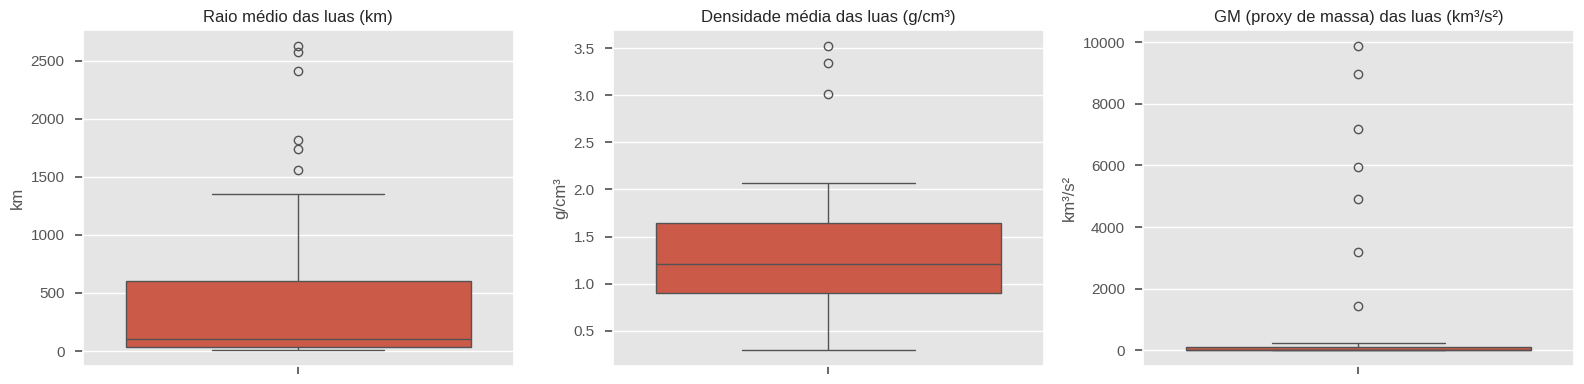

In [7]:
# ============================================
# 6.2 Distribuições das propriedades físicas
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.boxplot(y=df_base['mean_radius_km'], ax=axes[0])
axes[0].set_title('Raio médio das luas (km)')
axes[0].set_ylabel('km')

sns.boxplot(y=df_base['mean_density_g_cm3'], ax=axes[1])
axes[1].set_title('Densidade média das luas (g/cm³)')
axes[1].set_ylabel('g/cm³')

sns.boxplot(y=df_base['gm_km3_s2'], ax=axes[2])
axes[2].set_title('GM (proxy de massa) das luas (km³/s²)')
axes[2].set_ylabel('km³/s²')

plt.tight_layout()
plt.show()


## 6.3 Comparação das Propriedades Físicas por Sistema Planetário

Nesta subseção, comparamos a densidade média das luas entre diferentes sistemas planetários.
A densidade é uma variável particularmente relevante por refletir diferenças composicionais
(gelo versus material rochoso), sendo menos dependente do tamanho absoluto da lua.

O objetivo é identificar variações sistemáticas entre sistemas planetários e formular hipóteses
estatísticas a serem testadas na próxima etapa do projeto.


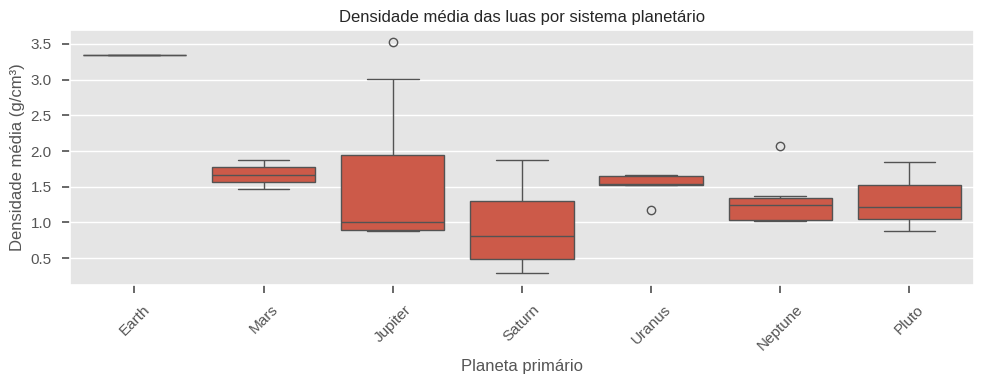

In [8]:
# ============================================
# 6.3 Densidade média das luas por planeta
# ============================================

plt.figure(figsize=(10, 4))
sns.boxplot(
    data=df_base,
    x='planet',
    y='mean_density_g_cm3'
)

plt.title('Densidade média das luas por sistema planetário')
plt.xlabel('Planeta primário')
plt.ylabel('Densidade média (g/cm³)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Interpretação Exploratória

A densidade média das luas apresenta variação sistemática entre os sistemas planetários.
Observa-se maior dispersão no sistema de Júpiter, indicando diversidade composicional,
enquanto Saturno concentra luas com densidades medianas mais baixas, compatíveis com
maior fração de gelo. Sistemas como Terra e Marte exibem densidades mais elevadas e
menor variabilidade.

Essas diferenças sugerem que a densidade das luas não é homogênea entre os sistemas,
motivando a aplicação de testes estatísticos na próxima etapa do projeto.


## 6.4 Relação entre Raio Médio e Densidade

Nesta etapa, analisamos a relação entre o raio médio e a densidade média das luas do Sistema Solar.
O objetivo é investigar a existência de padrões multivariados que não são evidentes em análises
univariadas, avaliando se essas propriedades combinadas sugerem a presença de grupos naturais
de luas com características físicas semelhantes.


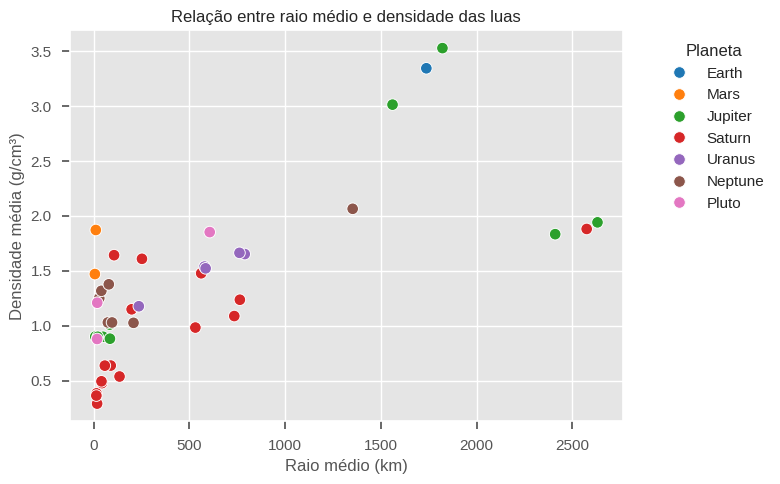

In [9]:
# ============================================
# 6.4 Relação bivariada: raio × densidade
# ============================================

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_base,
    x='mean_radius_km',
    y='mean_density_g_cm3',
    hue='planet',
    palette='tab10',
    s=70
)

plt.title('Relação entre raio médio e densidade das luas')
plt.xlabel('Raio médio (km)')
plt.ylabel('Densidade média (g/cm³)')
plt.legend(title='Planeta', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Interpretação Exploratória

A relação entre raio médio e densidade revela estrutura multivariada entre as luas do Sistema Solar,
com diferentes regiões ocupadas por corpos de tamanhos e composições distintas. Esse padrão sugere
a existência de grupos naturais de luas quando consideradas múltiplas propriedades físicas em
conjunto, justificando a aplicação de técnicas de clusterização nas próximas etapas.


## 7. Inferência Estatística — Testes de Hipótese

Nesta seção, aplicaremos testes estatísticos não paramétricos para avaliar formalmente as hipóteses
formuladas durante a Análise Exploratória de Dados (EDA). Em particular, investigaremos se as
diferenças observadas nas distribuições de densidade entre determinados grupos de luas são
estatisticamente significativas.

Os testes serão escolhidos de acordo com a natureza assimétrica das distribuições e a presença
de tamanhos amostrais distintos, garantindo consistência metodológica entre a EDA e a inferência
estatística.




**Objetivo desta seção**:

Avaliar formalmente, por meio de testes não paramétricos, se diferenças observadas na EDA (principalmente na densidade média) são estatisticamente significativas.

Por que testes não paramétricos?
As distribuições de raio e GM são altamente assimétricas e os tamanhos amostrais por planeta são diferentes; portanto, testes não paramétricos são mais apropriados.

Testes que vamos aplicar :

Kruskal–Wallis: comparar densidade entre múltiplos planetas (visão global).

Mann–Whitney U: comparar densidade entre dois grupos específicos (ex.: Júpiter × Saturno).



In [10]:
# ============================================
# 7.0 Preparação para testes estatísticos
# ============================================

# Vamos trabalhar com as colunas necessárias e remover NAs apenas na variável do teste
df_test = df_base[['planet', 'satellite', 'mean_radius_km', 'mean_density_g_cm3']].copy()

# Checar quantos valores ausentes existem na densidade (variável central aqui)
missing_density = df_test['mean_density_g_cm3'].isna().sum()

print(f"Total de luas: {len(df_test)}")
print(f"Valores ausentes em densidade: {missing_density}")

# Remover apenas linhas sem densidade (não vamos imputar, pois são parâmetros físicos consolidados)
df_test = df_test.dropna(subset=['mean_density_g_cm3']).copy()

print(f"Total após remover NAs em densidade: {len(df_test)}")

# Tamanho amostral por planeta (para sabermos os grupos do teste)
counts = df_test['planet'].value_counts()
display(counts.rename("n_luas_por_planeta"))


Total de luas: 46
Valores ausentes em densidade: 3
Total após remover NAs em densidade: 43


,n_luas_por_planeta
planet,
Saturn,16
Jupiter,9
Neptune,7
Uranus,5
Pluto,3
Mars,2
Earth,1


### 7.1 Teste Global: Kruskal–Wallis

Nesta etapa, aplicamos o teste de Kruskal–Wallis para avaliar se as distribuições
da densidade média das luas diferem significativamente entre os sistemas planetários.

Hipóteses:
- H₀: As distribuições de densidade média são iguais entre os planetas.
- H₁: Pelo menos um sistema planetário apresenta distribuição de densidade diferente.

O teste é não paramétrico e adequado para dados assimétricos e tamanhos amostrais distintos,
conforme identificado na Análise Exploratória de Dados.


In [11]:
# ============================================
# 7.1 Teste de Kruskal–Wallis (densidade por planeta)
# ============================================

# Agrupar densidades por planeta
groups = [
    df_test.loc[df_test['planet'] == planet, 'mean_density_g_cm3'].values
    for planet in df_test['planet'].unique()
]

# Executar o teste
stat, p_value = kruskal(*groups)

print(f"Estatística H: {stat:.4f}")
print(f"p-valor: {p_value:.6f}")


Estatística H: 10.8696
p-valor: 0.092492


### Conclusão — Teste de Kruskal–Wallis

O teste de Kruskal–Wallis aplicado às distribuições de densidade média das luas
por sistema planetário resultou em estatística H = 10.87 e p-valor = 0.092.

Ao nível de significância de 5%, não há evidência estatística suficiente para
rejeitar a hipótese nula de que as distribuições de densidade sejam iguais entre
os sistemas planetários analisados.

Apesar das diferenças visuais observadas na Análise Exploratória de Dados,
essas diferenças não se mostraram estatisticamente significativas no teste
global, considerando os tamanhos amostrais disponíveis.

Em síntese, podemos concluir que, com os dados atualmente disponíveis, não há evidência estatística suficiente para afirmar que as densidades médias das luas diferem de forma significativa entre os sistemas planetários analisados.


### 7.2 Teste Dirigido: Mann–Whitney U (Júpiter × Saturno)

Nesta etapa, realizamos um teste de Mann–Whitney U para comparar as distribuições
da densidade média das luas de Júpiter e Saturno.

Esta análise é conduzida de forma exploratória e dirigida, motivada pelas diferenças
visuais observadas na Análise Exploratória de Dados e por considerações físicas
relacionadas à composição das luas desses sistemas.

Hipóteses:
- H₀: As distribuições de densidade média das luas de Júpiter e Saturno são iguais.
- H₁: As distribuições de densidade média das luas de Júpiter e Saturno diferem.


In [12]:
# ============================================
# 7.2 Teste de Mann–Whitney U (Júpiter × Saturno)
# ============================================

# Selecionar densidades por planeta
density_jupiter = df_test.loc[df_test['planet'] == 'Jupiter', 'mean_density_g_cm3']
density_saturn  = df_test.loc[df_test['planet'] == 'Saturn',  'mean_density_g_cm3']

print(f"Júpiter - n = {len(density_jupiter)}")
print(f"Saturno - n = {len(density_saturn)}")

# Executar o teste (bicaudal)
u_stat, p_value = mannwhitneyu(
    density_jupiter,
    density_saturn,
    alternative='two-sided'
)

print(f"Estatística U: {u_stat:.4f}")
print(f"p-valor: {p_value:.6f}")


Júpiter - n = 9
Saturno - n = 16
Estatística U: 104.0000
p-valor: 0.074532


### Conclusão — Teste de Mann–Whitney U

O teste de Mann–Whitney U aplicado às densidades médias das luas de Júpiter e Saturno
resultou em estatística U = 104.0 e p-valor = 0.075.

Ao nível de significância de 5%, não há evidência estatística suficiente para rejeitar
a hipótese nula de que as distribuições de densidade média das luas desses dois sistemas
sejam diferentes.

Apesar da tendência observada na Análise Exploratória de Dados, os resultados indicam
que, com os dados disponíveis, essa diferença não pode ser considerada estatisticamente
significativa.

Em síntese, podemos concluir que não há evidência estatística robusta para afirmar que
as densidades médias das luas de Júpiter e Saturno diferem de forma significativa.


## 8. **Clusterização das Luas do Sistema Solar**

Nesta etapa, aplicamos técnicas de aprendizado não supervisionado com o objetivo de identificar grupos naturais de luas com base em suas propriedades físicas.

A clusterização permite analisar simultaneamente múltiplas variáveis (raio, densidade e proxy de massa), explorando padrões multivariados que não são evidentes em análises univariadas ou bivariadas.

Não são utilizados rótulos prévios; os grupos emergem exclusivamente da estrutura dos dados.


### 8.1 **Seleção das Variáveis e Tratamento de Escala**

A clusterização será realizada com base em três propriedades físicas das luas:
raio médio, densidade média e parâmetro gravitacional (GM).

Devido às diferentes ordens de grandeza e à forte assimetria das distribuições,
aplicamos uma padronização robusta antes da clusterização.


In [13]:
# ============================================
# 8.1 Seleção das variáveis para clusterização
# ============================================

features = [
    'mean_radius_km',
    'mean_density_g_cm3',
    'gm_km3_s2'
]

# Remover apenas linhas com valores ausentes nas variáveis usadas
df_cluster = df_base[features].dropna().copy()

print(f"Total de luas utilizadas na clusterização: {len(df_cluster)}")
display(df_cluster.head())


Total de luas utilizadas na clusterização: 43


,mean_radius_km,mean_density_g_cm3,gm_km3_s2
0,1737.40,3.3440,4902.800000
1,11.08,1.8720,0.000709
2,6.20,1.4710,0.000096
3,1821.49,3.5276,5959.915470
4,1560.80,3.0130,3202.712100


In [14]:
# ============================================
# 8.2 Padronização das variáveis
# ============================================

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Converter para DataFrame para facilitar inspeção
df_scaled = pd.DataFrame(
    X_scaled,
    columns=features,
    index=df_cluster.index
)

display(df_scaled.describe())


,mean_radius_km,mean_density_g_cm3,gm_km3_s2
count,43.000000,43.000000,43.000000
mean,0.644389,0.157669,8.751924
std,1.173106,0.962881,21.944783
min,-0.159244,-1.227868,-0.003269
25%,-0.105104,-0.414416,-0.003182
50%,0.000000,0.000000,0.000000
75%,0.894896,0.585584,0.996818
max,4.008415,3.099224,87.269853


### 8.3 **Definição do Número de Clusters**

Antes de aplicar o algoritmo de clusterização, avaliamos o número adequado de clusters.
Utilizamos métricas quantitativas (método do cotovelo e silhouette score), combinadas
com interpretação física, para evitar escolhas arbitrárias.


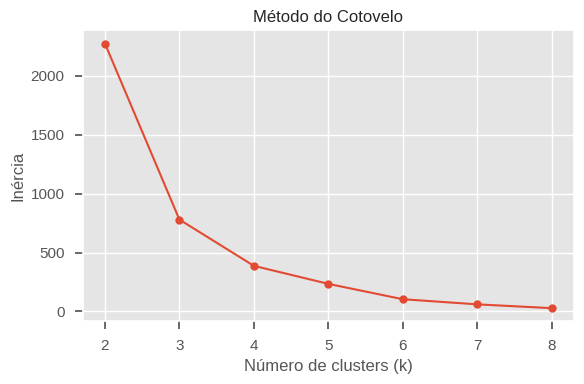

In [15]:
# ============================================
# 8.3.1 Método do Cotovelo
# ============================================

inertias = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.tight_layout()
plt.show()


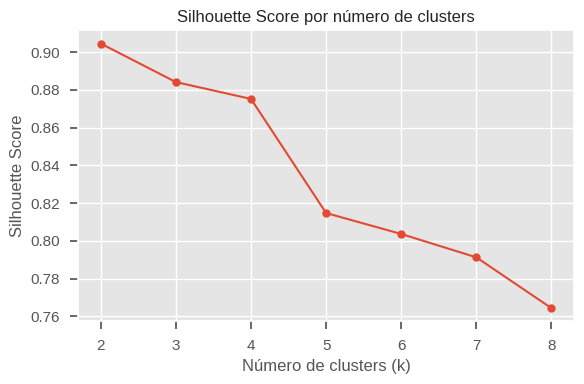

k = 2 → silhouette = 0.905
k = 3 → silhouette = 0.884
k = 4 → silhouette = 0.875
k = 5 → silhouette = 0.815
k = 6 → silhouette = 0.804
k = 7 → silhouette = 0.791
k = 8 → silhouette = 0.764


In [16]:
# ============================================
# 8.3.2 Silhouette Score
# ============================================

sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por número de clusters')
plt.tight_layout()
plt.show()

for k, s in zip(k_range, sil_scores):
    print(f"k = {k} → silhouette = {s:.3f}")


### 8.4 Escolha do Número de Clusters

Com base no método do cotovelo e no silhouette score, optamos por k = 4.
Esse valor representa um equilíbrio entre qualidade de separação dos grupos
e capacidade de capturar a diversidade física das luas do Sistema Solar.


### 8.5 Aplicação do K-Means

Nesta etapa, aplicamos o algoritmo K-Means com k = 4 para identificar grupos
naturais de luas com base em suas propriedades físicas padronizadas.

Os rótulos dos clusters serão adicionados ao dataset para posterior análise
e interpretação física.


In [17]:
# ============================================
# 8.5 Aplicação do K-Means (k = 4)
# ============================================

kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# Adicionar rótulos ao dataframe de clusterização
df_clustered = df_cluster.copy()
df_clustered['cluster'] = labels

# Juntar com informações descritivas (planeta e nome da lua)
df_result = df_base.loc[df_clustered.index].copy()
df_result['cluster'] = labels

display(df_result.head())


,planet,satellite,code,gm_km3_s2,mean_radius_km,mean_density_g_cm3,cluster
0,Earth,Moon,301,4902.800000,1737.40,3.3440,2
1,Mars,Phobos,401,0.000709,11.08,1.8720,0
2,Mars,Deimos,402,0.000096,6.20,1.4710,0
3,Jupiter,Io,501,5959.915470,1821.49,3.5276,1
4,Jupiter,Europa,502,3202.712100,1560.80,3.0130,2


In [18]:
# ============================================
# 8.6 Estatísticas descritivas por cluster
# ============================================

cluster_summary = (
    df_result
    .groupby('cluster')[features]
    .agg(['count', 'mean', 'median'])
)

display(cluster_summary)


mean_radius_km                     mean_density_g_cm3            \
                 count      mean    median              count      mean   
cluster                                                                   
0                   37   251.240    85.000                 37  1.123197   
1                    2  2115.895  2115.895                  2  2.680800   
2                    2  1649.100  1649.100                  2  3.178500   
3                    2  2602.980  2602.980                  2  1.911500   

                gm_km3_s2                            
         median     count         mean       median  
cluster                                              
0        1.0887        37    68.725247     0.164560  
1        2.6808         2  6569.599435  6569.599435  
2        3.1785         2  4052.756050  4052.756050  
3        1.9115         2  9432.984925  9432.984925

### 8.7 Visualização dos Clusters

Nesta etapa, visualizamos os clusters identificados pelo K-Means para facilitar
a interpretação física dos grupos. Utilizamos a relação entre raio médio e densidade,
colorindo os pontos de acordo com o cluster atribuído.


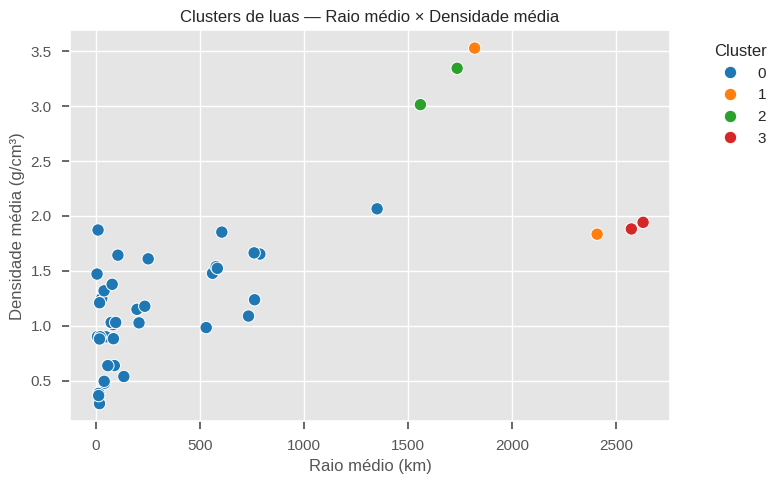

In [19]:
# ============================================
# 8.7 Visualização dos clusters
# ============================================

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_result,
    x='mean_radius_km',
    y='mean_density_g_cm3',
    hue='cluster',
    palette='tab10',
    s=80
)

plt.title('Clusters de luas — Raio médio × Densidade média')
plt.xlabel('Raio médio (km)')
plt.ylabel('Densidade média (g/cm³)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 8.8 Interpretação Física dos Clusters

Os clusters identificados refletem diferenças físicas claras entre as luas:

- Clusters com raios pequenos e baixas densidades concentram luas menores e
  predominantemente ricas em gelo.
- Clusters intermediários reúnem luas de tamanho médio, com composições mistas.
- Clusters com grandes raios e altas densidades representam luas maiores e mais
  rochosas, com maior massa gravitacional.

Esses grupos emergem diretamente das propriedades físicas, sem uso de rótulos
pré-definidos, corroborando a hipótese central do projeto.


### 8.9 Validação Visual da Clusterização

Utilizamos ferramentas visuais do Yellowbrick para avaliar a separação e coesão
dos clusters obtidos, complementando as métricas quantitativas apresentadas
anteriormente.


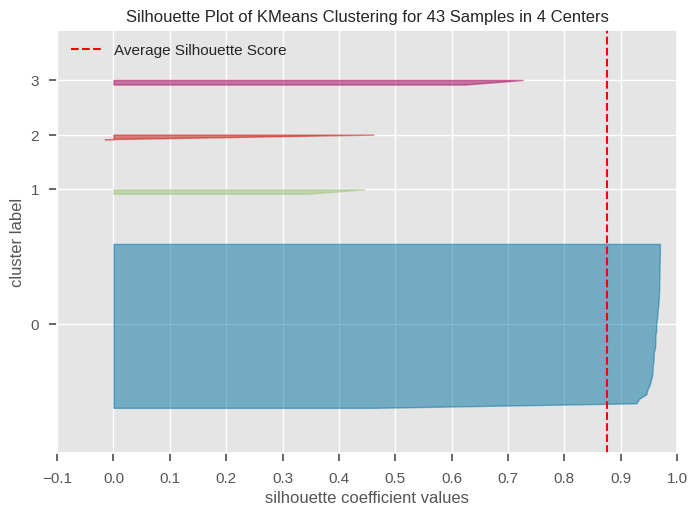

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 43 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
# ============================================
# 8.9.1 Silhouette Visualizer (Yellowbrick)
# ============================================

model = KMeans(n_clusters=4, random_state=42, n_init=20)

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()


O gráfico de silhouette confirma boa separação entre os clusters, com valores
predominantemente positivos e distribuição equilibrada entre os grupos,
indicando uma clusterização consistente.


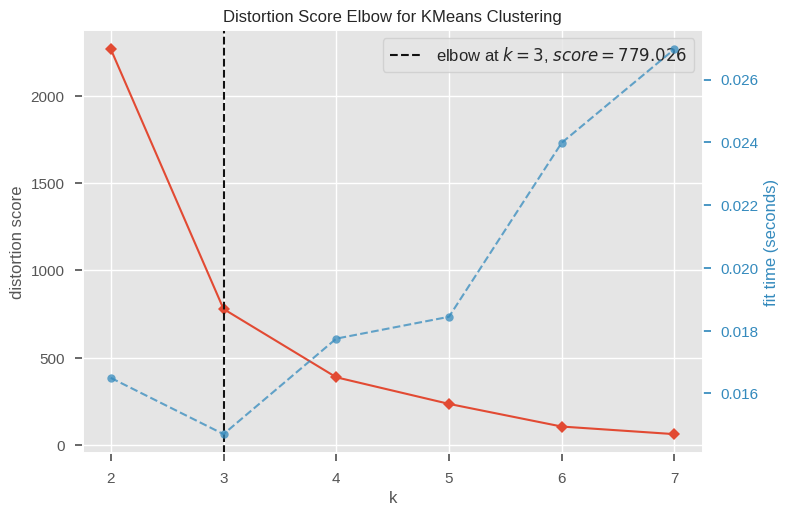

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# ============================================
# 8.9.2 KElbowVisualizer (reforço visual)
# ============================================

model = KMeans(random_state=42, n_init=20)

visualizer = KElbowVisualizer(
    model,
    k=(2, 8),
    metric='distortion'
)

visualizer.fit(X_scaled)
visualizer.show()


O método do cotovelo indica que a maior redução de distorção ocorre até k = 3, sendo que, a partir desse ponto, os ganhos tornam-se marginais.

### 8.10 Análise Dirigida de um Cluster

Nesta etapa, realizamos uma análise detalhada de um cluster específico, com o objetivo
de caracterizar seu perfil físico e identificar quais luas o compõem.


In [22]:
# ============================================
# 8.10.1 Seleção de um cluster para análise dirigida
# ============================================

# Identificar a densidade mediana por cluster
cluster_density_median = (
    df_result
    .groupby('cluster')['mean_density_g_cm3']
    .median()
    .sort_values(ascending=False)
)

display(cluster_density_median)


,mean_density_g_cm3
cluster,
2,3.1785
1,2.6808
3,1.9115
0,1.0887


In [23]:
# Selecionar o cluster com maior densidade mediana
cluster_focus = cluster_density_median.index[0]
print(f"Cluster selecionado para análise dirigida: {cluster_focus}")


Cluster selecionado para análise dirigida: 2


In [24]:
# Listar luas pertencentes ao cluster selecionado
df_cluster_focus = df_result[df_result['cluster'] == cluster_focus].copy()

display(
    df_cluster_focus[
        ['planet', 'satellite', 'mean_radius_km', 'mean_density_g_cm3', 'gm_km3_s2']
    ].sort_values('mean_radius_km', ascending=False)
)


,planet,satellite,mean_radius_km,mean_density_g_cm3,gm_km3_s2
0,Earth,Moon,1737.4,3.344,4902.8000
4,Jupiter,Europa,1560.8,3.013,3202.7121


O cluster analisado concentra luas com maiores densidades médias e raios elevados,
indicando corpos predominantemente rochosos e com maior massa gravitacional.
Essas características são compatíveis com luas formadas em ambientes mais quentes
ou submetidas a processos de diferenciação interna mais intensos.


### 8.11 Análise Dirigida — Comparação com os Demais Clusters

Nesta análise, comparamos o cluster mais denso com os demais clusters,
avaliando como suas propriedades físicas se diferenciam no contexto global
das luas do Sistema Solar.


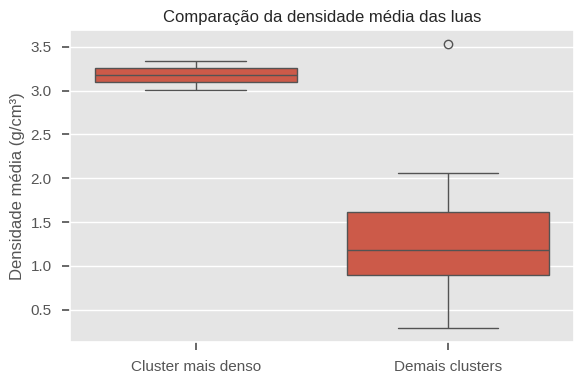

In [25]:
# ============================================
# 8.11 Comparação: cluster denso vs demais
# ============================================

df_result['cluster_type'] = np.where(
    df_result['cluster'] == cluster_focus,
    'Cluster mais denso',
    'Demais clusters'
)

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_result,
    x='cluster_type',
    y='mean_density_g_cm3'
)

plt.title('Comparação da densidade média das luas')
plt.xlabel('')
plt.ylabel('Densidade média (g/cm³)')
plt.tight_layout()
plt.show()


O cluster selecionado apresenta densidades consistentemente mais elevadas em
relação aos demais clusters, destacando-se como um grupo físico extremo.
Essa separação reforça a interpretação de que essas luas possuem composição
predominantemente rochosa, diferenciando-se do conjunto majoritário de luas
ricas em gelo.


# ***Conclusão***

A análise conjunta das propriedades físicas das luas do Sistema Solar revela uma estrutura altamente heterogênea, marcada por fortes assimetrias em tamanho, densidade e massa gravitacional. A análise exploratória e os testes estatísticos indicam que, apesar de diferenças visuais entre sistemas planetários, não há evidência estatística robusta de variações globais significativas na densidade média quando considerados todos os grupos de luas.

A aplicação de técnicas de aprendizado não supervisionado permitiu identificar grupos naturais de luas com características físicas semelhantes, evidenciando padrões multivariados que não são capturados por análises univariadas. Em particular, emergem clusters associados a luas pequenas e ricas em gelo, grupos intermediários de composição mista e um conjunto restrito de luas grandes e densas, fisicamente distinto e bem separado no espaço das variáveis analisadas.

**Em termos gerais, a resposta é que as luas do Sistema Solar se organizam naturalmente em grupos físicos bem definidos quando analisadas em conjunto, refletindo diferenças reais de tamanho, composição e história de formação, sem a necessidade de rótulos pré-definidos.**